# Drug Classification With A Vision Transformer

In [1]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 5.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
#mouting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

#necessary imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
import os
from PIL import Image
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import math
from torchvision.transforms.functional import to_tensor
import random

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU")

GPU is not available, using CPU


In [5]:
# Setting seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Hyperparameters & Architecture details
NUM_CLASSES = 10
IMAGE_SIZE = 72
BATCH_SIZE = 32
EPOCHS = 100
PATCH_SIZE = 6
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [PROJECTION_DIM * 2, PROJECTION_DIM]
MLP_HEAD_UNITS = [2048, 1024]
LEARNING_RATE = 0.00001
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8

In [6]:
path = 'drive/MyDrive/dataset/'
train_dir = os.path.join(path, 'train')
test_dir = os.path.join(path, 'test')

# Define transforms for training and testing datasets separately
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    #transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(degrees=(-2, 2)),
    # transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
])


test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    #transforms.ToTensor()
])



images = []
for root, _, files in os.walk(train_dir):
    for file in files:
        if file.endswith(".jpg") or file.endswith(".png"):
            images.append(os.path.join(root, file))
images = random.sample(images,7000)

class_to_index = {}
classes = os.listdir(train_dir)
for i, class_name in enumerate(classes):
    class_to_index[class_name] = i


train_images = []
train_labels = []
for i in range(4000):
    image = Image.open(images[i]).convert('RGB')
    transformed = train_transform(image)
    numpy_image = np.array(transformed)
    drug = images[i].split("/")[4]
    cls = class_to_index[drug]
    train_labels.append(cls)
    train_images.append(numpy_image)

    if i % 500 == 0:
        print(i)


0


KeyboardInterrupt: 

In [ ]:
X = torch.tensor(train_images).to(device)

In [ ]:
Y = torch.LongTensor(train_labels).to(device)

In [ ]:
Y.shape

# Plotting some training examples

In [ ]:
plt.imshow(X[4].cpu())
plt.title('EXAMPLE 1')
plt.show()
plt.imshow(X[600].cpu())
plt.title('EXAMPLE 2')

In [127]:
train_dataset = torch.utils.data.TensorDataset(X,Y)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Training

In [128]:
# Define Multilayer Perceptron (MLP)
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_units, output_dim, dropout_rate=0.5):
        super(MLP, self).__init__()
        self.fc_layers = nn.ModuleList()
        self.dropout = nn.Dropout(dropout_rate)

        for units in hidden_units:
            self.fc_layers.append(nn.Linear(input_dim, units))
            input_dim = units
        self.output_layer = nn.Linear(hidden_units[-1], output_dim)

    def forward(self, x):
        for layer in self.fc_layers:
            x = F.gelu(layer(x))
            x = self.dropout(x)
        x = self.output_layer(x)
        return x

# Patch Creation Layer
class Patches(nn.Module):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size


    def forward(self, images):
        batch_size, width, height, channels = images.shape
        images = images.permute(0, 3, 1, 2)  # Change data shape to [batch, channels, height, width]

        # Use unfold to extract patches
        patches = images.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        #print(patches.shape)  # Shape will be [batch, channels, 12, 12, 6, 6]

        # Reshape to flatten the patches
        patches = patches.contiguous().view(batch_size, channels, -1, self.patch_size*self.patch_size)
        patches = patches.permute(0, 2, 1, 3)  # Reordering to [batch, num_patches, channels, patch_size*patch_size]
        patches = patches.reshape(batch_size, -1, self.patch_size*self.patch_size*channels)
        return patches

# Patch Encoding Layer
class PatchEncoder(nn.Module):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.projection = nn.Linear(108,projection_dim)
        self.position_embedding = nn.Parameter(torch.randn(1, num_patches, projection_dim))

    def forward(self, patch):
        encoded = self.projection(patch) + self.position_embedding
        return encoded

# Multi-Head Self-Attention with Learnable Scaling
class MultiHeadAttentionLSA(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.scale = math.sqrt(self.head_dim)

        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        batch_size = query.shape[0]

        Q = self.query(query).view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        K = self.key(key).view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        V = self.value(value).view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        if mask is not None:
            energy = energy.masked_fill(mask == 0, float('-inf'))

        attention = torch.softmax(energy, dim=-1)
        attention = self.dropout(attention)

        x = torch.matmul(attention, V)

        x = x.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.embed_dim)

        return x

# Vision Transformer Model
class VisionTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        #self.data_augmentation = train_transform
        self.patches = Patches(PATCH_SIZE)
        self.encoder = PatchEncoder(NUM_PATCHES, PROJECTION_DIM)
        self.transformers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=PROJECTION_DIM, nhead=NUM_HEADS)
            for _ in range(TRANSFORMER_LAYERS)
        ])
        self.layer_norm = nn.LayerNorm(PROJECTION_DIM)
        self.mlp_head = MLP(PROJECTION_DIM * NUM_PATCHES, MLP_HEAD_UNITS, NUM_CLASSES)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        #x = self.data_augmentation(x)
        patches = self.patches(x)
        encoded_patches = self.encoder(patches)

        for transformer in self.transformers:
            encoded_patches = transformer(encoded_patches)

        representation = self.layer_norm(encoded_patches)
        representation = representation.flatten(1)
        logits = self.mlp_head(representation)
        pred = self.softmax(logits)
        return pred










In [129]:
from torchmetrics import Accuracy,F1Score,Precision,Recall

In [130]:
# Initialize metrics
accuracy = Accuracy(num_classes=NUM_CLASSES,task='multiclass').to(device)
precision = Precision(num_classes=NUM_CLASSES,task='multiclass').to(device)
recall = Recall(num_classes=NUM_CLASSES,task='multiclass').to(device)
f1_score = F1Score(num_classes=NUM_CLASSES,task='multiclass').to(device)

def calculate_metrics(preds, labels, accuracy, precision, recall, f1_score):
    # Compute metrics
    acc = accuracy(preds, labels)
    prec = precision(preds, labels)
    rec = recall(preds, labels)
    f1 = f1_score(preds, labels)

    # Reset metrics after computation to prepare for next batch
    accuracy.reset()
    precision.reset()
    recall.reset()
    f1_score.reset()

    # Collect results
    results = {
        'accuracy': acc.item(),
        'precision': prec.item(),
        'recall': rec.item(),
        'f1_score': f1.item()
    }

    return results




In [163]:
model = VisionTransformer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [164]:
# Training loop
losses = []
accuracies = []
metrics = {}
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for i,(images_, label) in enumerate(train_loader):
        images_ = images_.float()
        optimizer.zero_grad()
        outputs = model(images_)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        results = calculate_metrics(outputs.argmax(axis=1), label, accuracy, precision, recall, f1_score)

        losses.append(loss.item())
        accuracies.append(results['accuracy'])
        if (i+1) % 125 == 0:
            metrics = results
            print(f'Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}')
            print(metrics)
            running_loss = 0.0


Epoch [1/100], Step [125/125], Loss: 2.8082
{'accuracy': 0.21875, 'precision': 0.21875, 'recall': 0.21875, 'f1_score': 0.21875}
Epoch [2/100], Step [125/125], Loss: 2.7974
{'accuracy': 0.09375, 'precision': 0.09375, 'recall': 0.09375, 'f1_score': 0.09375}
Epoch [3/100], Step [125/125], Loss: 2.8003
{'accuracy': 0.15625, 'precision': 0.15625, 'recall': 0.15625, 'f1_score': 0.15625}
Epoch [4/100], Step [125/125], Loss: 2.7961
{'accuracy': 0.15625, 'precision': 0.15625, 'recall': 0.15625, 'f1_score': 0.15625}
Epoch [5/100], Step [125/125], Loss: 2.7948
{'accuracy': 0.21875, 'precision': 0.21875, 'recall': 0.21875, 'f1_score': 0.21875}
Epoch [6/100], Step [125/125], Loss: 2.7892
{'accuracy': 0.0625, 'precision': 0.0625, 'recall': 0.0625, 'f1_score': 0.0625}
Epoch [7/100], Step [125/125], Loss: 2.7892
{'accuracy': 0.21875, 'precision': 0.21875, 'recall': 0.21875, 'f1_score': 0.21875}
Epoch [8/100], Step [125/125], Loss: 2.7869
{'accuracy': 0.25, 'precision': 0.25, 'recall': 0.25, 'f1_score'

# Metrics Visualisation

In [148]:
torch.bincount(Y)

tensor([700, 700, 700, 700, 700, 500], device='cuda:0')

Text(0, 0.5, 'LOSS')

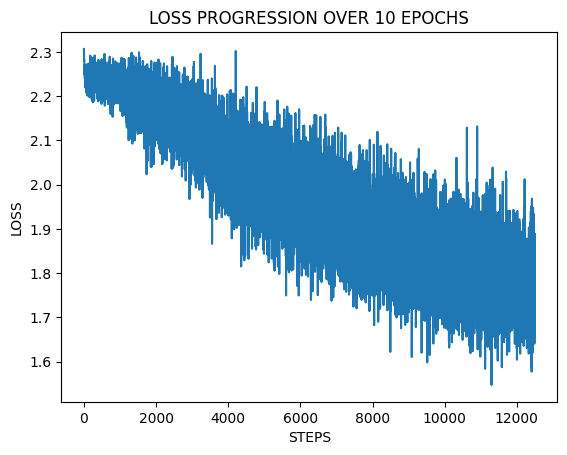

In [166]:
plt.plot(losses)
plt.title("Loss progression over 10 epochs".upper())
plt.xlabel('steps'.upper())
plt.ylabel('loss'.upper())

Text(0, 0.5, 'ACCURACY')

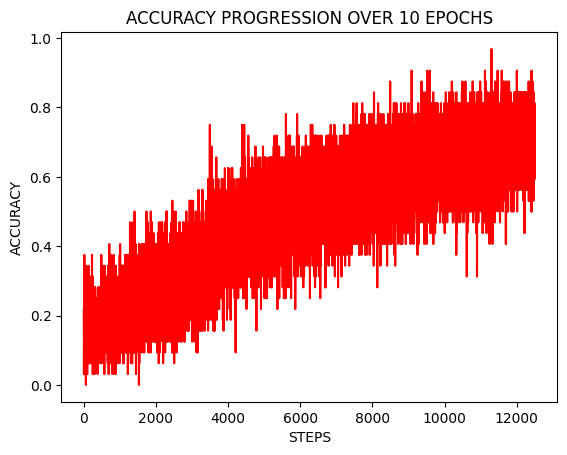

In [167]:
plt.plot(accuracies,'r')
plt.title("Accuracy progression over 10 epochs".upper())
plt.xlabel('steps'.upper())
plt.ylabel('accuracy'.upper())

# TEST SET

In [153]:
images = []
for root, _, files in os.walk(train_dir):
    for file in files:
        if file.endswith(".jpg") or file.endswith(".png"):
            images.append(os.path.join(root, file))

In [154]:
test_images = []
test_labels = []
for i in range(4000,7000):
    image = Image.open(images[i]).convert('RGB')
    transformed = test_transform(image)
    numpy_image = np.array(transformed)
    drug = images[i].split("/")[4]
    cls = class_to_index[drug]
    test_labels.append(cls)
    test_images.append(numpy_image)

    if i % 500 == 0:
        print(i)


4000
4500
5000
5500
6000
6500


In [155]:
Xt = torch.tensor(train_images).to(device)
Yt = torch.LongTensor(train_labels).to(device)

In [156]:
test_dataset = torch.utils.data.TensorDataset(Xt,Yt)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.70      0.85      0.77       700
           1       0.77      0.81      0.79       700
           2       0.69      0.81      0.74       700
           3       0.70      0.93      0.80       700
           4       0.92      0.86      0.89       700
           5       0.00      0.00      0.00       500

    accuracy                           0.75      4000
   macro avg       0.63      0.71      0.66      4000
weighted avg       0.66      0.75      0.70      4000



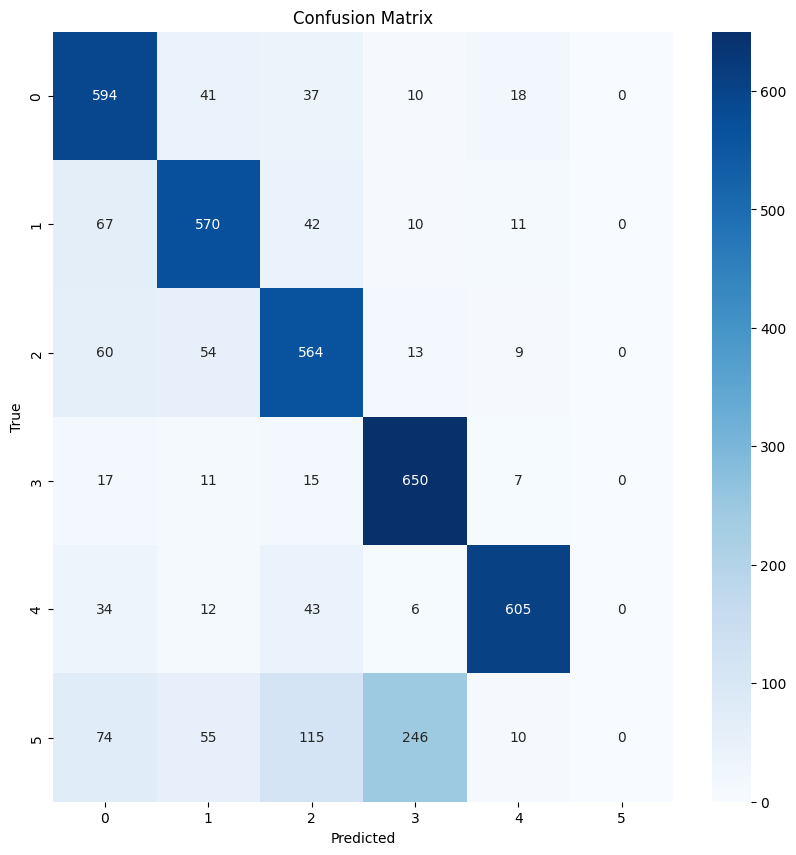

In [170]:
# Evaluation
model.eval()
all_labels = []
all_preds = []
with torch.no_grad():
    for images, label in test_loader:
        images = images.float()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(label.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Classification report and confusion matrix
print(classification_report(all_labels, all_preds))
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [169]:
torch.save(model.state_dict(), 'drive/MyDrive/dataset/model_weights.pth')